In [19]:
!pip3 install -U gensim

     |████████████████████████████████| 24.0 MB 3.5 MB/s eta 0:00:011
     |████████████████████████████████| 58 kB 1.7 MB/s eta 0:00:011


In [23]:
#Importing warning library to avoid any warnings
import warnings
warnings.filterwarnings('ignore')

In [24]:
import pandas as pd
df=pd.read_csv('Rating_data.csv') 
df  #Checking the dataset

,Unnamed: 0,Product_Review,Ratings
0,0,It has great sound quality and bass but after ...,1.0
1,1,"[BIG UPDATE]IT BROKE ALONG THE RIGHT HINGE, I ...",2.0
2,2,This is a premium quality product from boAt-Li...,5.0
3,3,The boAt Rockerz line is boAt's super cheap li...,1.0
4,4,These are super comfortable and premium lookin...,5.0
...,...,...,...
49995,49995,Honest rating for this product is 5/5 . Just f...,4.0
49996,49996,"I have bought 3 of these little guys, for my s...",5.0
49997,49997,Its a great product. Works really fine. It wil...,4.0
49998,49998,"Service is very good , I would say to keep up ...",5.0


In [25]:
#We can see that Unnamed:0 is just the index number.lets drop that column
df.drop('Unnamed: 0',axis=1,inplace=True)

In [26]:
df.shape

(50000, 2)

In [27]:
#Checking for null values 
df.isnull().sum()

Product_Review    80
Ratings            0
dtype: int64

In [28]:
#We can handle missing data by filling them with 'No Review' using fillna()
df['Product_Review'].fillna('No review',inplace=True)

In [29]:
df.isnull().sum()

Product_Review    0
Ratings           0
dtype: int64

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Product_Review  50000 non-null  object 
 1   Ratings         50000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 781.4+ KB


In [31]:
#Checking the average rating given by the users
avg = df['Ratings'].mean()
Avg = round(avg,1)
print("Average rating given by users is " + str(Avg))

Average rating given by users is 3.7


In [32]:
#Checking the value counts of the rating
df['Ratings'].value_counts()

5.0    24506
1.0    11232
4.0     8406
3.0     3680
2.0     2176
Name: Ratings, dtype: int64

In [33]:
#Importing Matplotlib and Seaborn
import seaborn as sns
import matplotlib.pyplot as plt

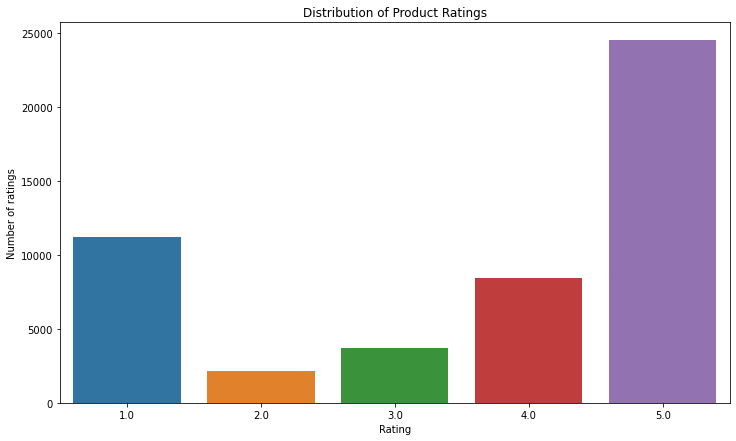

In [34]:
f, axes = plt.subplots(figsize=(12,7))
ax = sns.countplot(x=df['Ratings'])
ax.set(title="Distribution of Product Ratings", xlabel="Rating", ylabel="Number of ratings")
plt.show()

In [35]:
#Importing required libraries
import re # for regex
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud

In [36]:
def clean_text(df, df_column_name):
    
    #Converting all messages to lowercase
    df[df_column_name] = df[df_column_name].str.lower()

    #Replace email addresses with 'email'
    df[df_column_name] = df[df_column_name].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','emailaddress')

    #Replace URLs with 'webaddress'
    df[df_column_name] = df[df_column_name].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','webaddress')

    #Replace money symbols with 'dollars' (£ can by typed with ALT key + 156)
    df[df_column_name] = df[df_column_name].str.replace(r'£|\$', 'dollars')
      
    #Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
    df[df_column_name] = df[df_column_name].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber')

    #Replace numbers with 'numbr'
    df[df_column_name] = df[df_column_name].str.replace(r'\d+(\.\d+)?', 'numbr')

    #Remove punctuation
    df[df_column_name] = df[df_column_name].str.replace(r'[^\w\d\s]', ' ')

    #Replace whitespace between terms with a single space
    df[df_column_name] = df[df_column_name].str.replace(r'\s+', ' ')

    #Remove leading and trailing whitespace
    df[df_column_name] = df[df_column_name].str.replace(r'^\s+|\s+?$', '')
    
    #Remove stopwords
    stop_words = set(stopwords.words('english') + ['u', 'ü', 'â', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])
    df[df_column_name] = df[df_column_name].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

In [37]:
#Calling the class
clean_text(df, 'Product_Review')
df['Product_Review'].tail(3)

49997    great product works really fine usually numbr ...
49998    service good would say keep good work goin fli...
49999    buy need bigger coverage buy repeater router c...
Name: Product_Review, dtype: object

In [38]:
#Tokenizing the data using RegexpTokenizer
from nltk.tokenize import RegexpTokenizer
tokenizer=RegexpTokenizer(r'\w+')
df['Product_Review'] = df['Product_Review'].apply(lambda x: tokenizer.tokenize(x.lower()))
df.head()

,Product_Review,Ratings
0,"[great, sound, quality, bass, numbr, months, u...",1.0
1,"[big, update, broke, along, right, hinge, wear...",2.0
2,"[premium, quality, product, boat, lifestyle, p...",5.0
3,"[boat, rockerz, line, boat, super, cheap, line...",1.0
4,"[super, comfortable, premium, looking, headpho...",5.0


In [39]:
# Lemmatizing and then Stemming with Snowball to get root words and further reducing characters
stemmer = SnowballStemmer("english")
import gensim
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text,pos='v'))

#Tokenize and Lemmatize
def preprocess(text):
    result=[]
    for token in text:
        if len(token)>=3:
            result.append(lemmatize_stemming(token))
            
    return result

In [41]:
conda install -c anaconda nltk

Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/osx-64::xgboost==1.5.1=cpu_py39h037b50c_2
  - defaults/osx-64::scikit-learn-intelex==2021.3.0=py39hecd8cb5_0
  - defaults/osx-64::_anaconda_depends==2021.11=py39_0
  - defaults/osx-64::anaconda==custom=py39_1
  - conda-forge/osx-64::py-xgboost==1.5.1=cpu_py39hb0a6171_2
done

## Package Plan ##

  environment location: /Users/manasnayak/opt/anaconda3

  added / updated specs:
    - nltk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.10.14 |                0         127 KB  anaconda
    nltk-3.5                   |             py_0         1.1 MB  anaconda
    scikit-learn-1.0.2         |   py39hae1ba45_1         5.3 MB
    ------------------------------------------------------------
                 

In [43]:
 import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/manasnayak/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [44]:
#Processing review with above Function
processed_review = []

for doc in df.Product_Review:
    processed_review.append(preprocess(doc))
    
print(len(processed_review))
processed_review[:3]

50000


[['great',
  'sound',
  'qualiti',
  'bass',
  'numbr',
  'month',
  'use',
  'get',
  'break',
  'without',
  'fall',
  'jerk',
  'wear',
  'normal',
  'get',
  'break',
  'one',
  'side',
  'call',
  'costum',
  'care',
  'servic',
  'repli',
  'come',
  'also',
  'file',
  'complaint',
  'boat',
  'offici',
  'websit',
  'warranti',
  'claim',
  'respond',
  'come',
  'servic',
  'center',
  'approach',
  'claim',
  'numbr',
  'wast'],
 ['big',
  'updat',
  'break',
  'along',
  'right',
  'hing',
  'wear',
  'normal',
  'split',
  'open',
  'one',
  'side',
  'extend',
  'weak',
  'pic',
  'inscud',
  'boat',
  'numbr',
  'break',
  'centr',
  'need',
  'concentr',
  'less',
  'celebr',
  'endors',
  'use',
  'profit',
  'materi',
  'qualiti',
  'control',
  'still',
  'work',
  'tap',
  'metal',
  'sheet',
  'still',
  'give',
  'numbr',
  'star',
  'sound',
  'origin',
  'review',
  'own',
  'boat',
  'product',
  'rockerz',
  'numbr',
  'earphon',
  'best',
  'experi',
  'produc

In [45]:
df['clean_review']=processed_review  #Assigning this to the dataframe
df.head()

,Product_Review,Ratings,clean_review
0,"[great, sound, quality, bass, numbr, months, u...",1.0,"[great, sound, qualiti, bass, numbr, month, us..."
1,"[big, update, broke, along, right, hinge, wear...",2.0,"[big, updat, break, along, right, hing, wear, ..."
2,"[premium, quality, product, boat, lifestyle, p...",5.0,"[premium, qualiti, product, boat, lifestyl, pr..."
3,"[boat, rockerz, line, boat, super, cheap, line...",1.0,"[boat, rockerz, line, boat, super, cheap, line..."
4,"[super, comfortable, premium, looking, headpho...",5.0,"[super, comfort, premium, look, headphon, beau..."


In [46]:
df['Product_Review'] = df['clean_review'].apply(lambda x:' '.join(y for y in x))
df.head()

,Product_Review,Ratings,clean_review
0,great sound qualiti bass numbr month use get b...,1.0,"[great, sound, qualiti, bass, numbr, month, us..."
1,big updat break along right hing wear normal s...,2.0,"[big, updat, break, along, right, hing, wear, ..."
2,premium qualiti product boat lifestyl professi...,5.0,"[premium, qualiti, product, boat, lifestyl, pr..."
3,boat rockerz line boat super cheap lineup budg...,1.0,"[boat, rockerz, line, boat, super, cheap, line..."
4,super comfort premium look headphon beauti des...,5.0,"[super, comfort, premium, look, headphon, beau..."


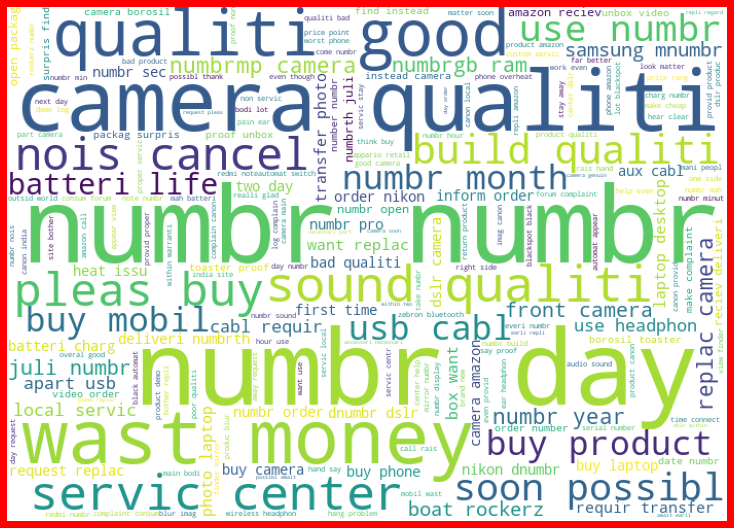

In [47]:
#Getting sense of words in Rating 1
one = df['Product_Review'][df['Ratings']==1.0]

one_cloud = WordCloud(width=700,height=500,background_color='white',max_words=200).generate(' '.join(one))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(one_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

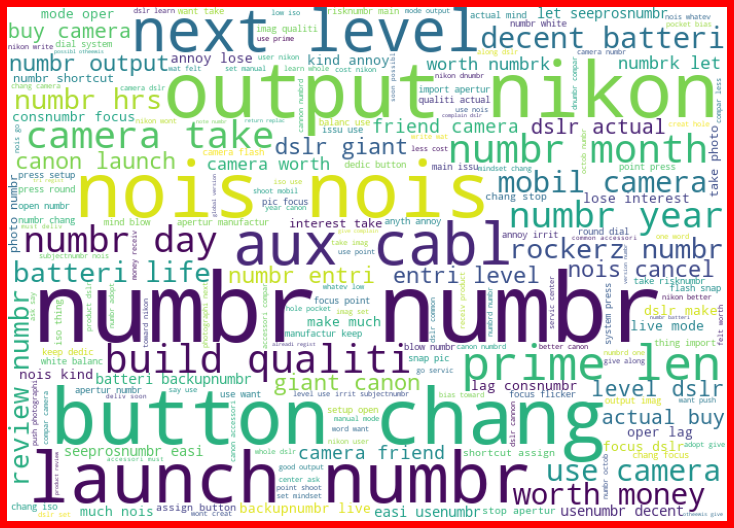

In [48]:
#Getting sense of words in Rating 2
one = df['Product_Review'][df['Ratings']==2.0]

one_cloud = WordCloud(width=700,height=500,background_color='white',max_words=200).generate(' '.join(one))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(one_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

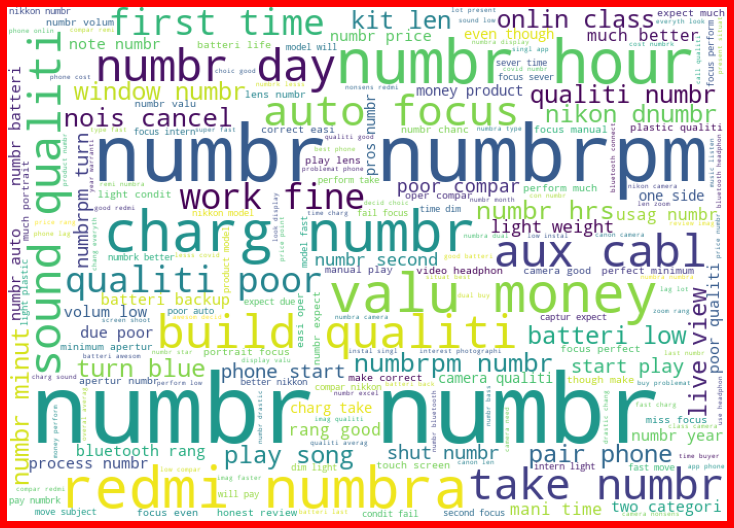

In [49]:
#Getting sense of words in Rating 3
one = df['Product_Review'][df['Ratings']==3.0]

one_cloud = WordCloud(width=700,height=500,background_color='white',max_words=200).generate(' '.join(one))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(one_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

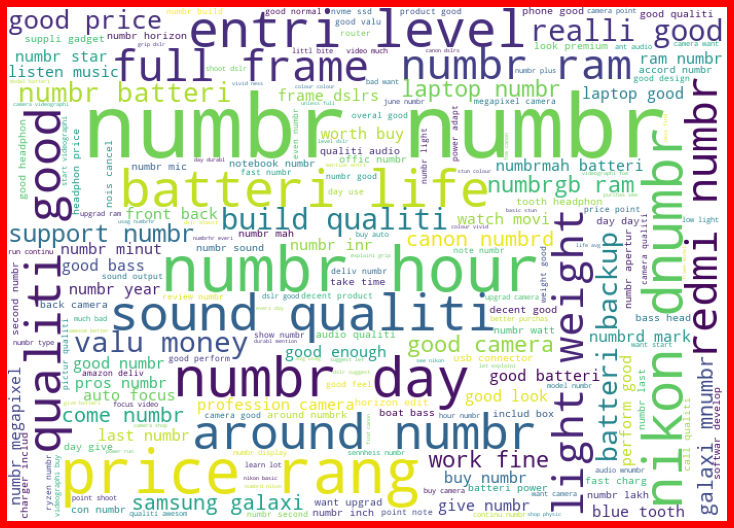

In [50]:
#Getting sense of words in Rating 4
one = df['Product_Review'][df['Ratings']==4.0]

one_cloud = WordCloud(width=700,height=500,background_color='white',max_words=200).generate(' '.join(one))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(one_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

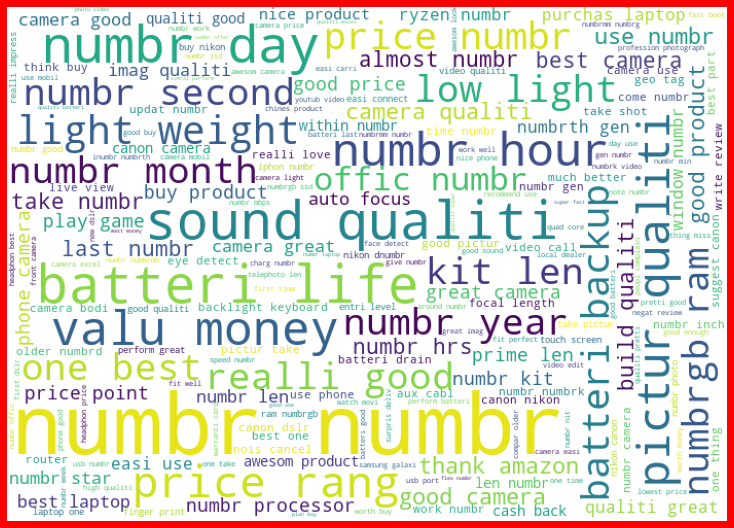

In [51]:
#Getting sense of words in Rating 5
one = df['Product_Review'][df['Ratings']==5.0]

one_cloud = WordCloud(width=700,height=500,background_color='white',max_words=200).generate(' '.join(one))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(one_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [52]:
#Converting text into numeric using TfidfVectorizer
#create object
tf = TfidfVectorizer()

#fitting 
features = tf.fit_transform(df['Product_Review'])
x=features
y=df[['Ratings']]

In [53]:
x.shape

(50000, 5828)

In [54]:
y.shape

(50000, 1)

Model building

In [55]:
#Importing train_test_split, Logistic Regression and accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [56]:
def max_acc_score(reg,x,y):
    max_score=0
    for r_state in range (42,101):
        x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=r_state,test_size=0.20)
        reg.fit(x_train,y_train)
        pred=reg.predict(x_test)
        acc_score=accuracy_score(y_test,pred)
        print("The accuracy score at r_state", r_state, "is", acc_score)
        if acc_score>max_score:
            max_score=acc_score
            final_r_state=r_state
    print("The maximum accuracy score", max_score, "is achieved at", final_r_state)
    return max_score

In [57]:
LR=LogisticRegression()
max_acc_score(LR,x,y)

The accuracy score at r_state 42 is 0.9031
The accuracy score at r_state 43 is 0.9024
The accuracy score at r_state 44 is 0.9049
The accuracy score at r_state 45 is 0.9009
The accuracy score at r_state 46 is 0.9054
The accuracy score at r_state 47 is 0.9038
The accuracy score at r_state 48 is 0.9037
The accuracy score at r_state 49 is 0.8998
The accuracy score at r_state 50 is 0.9016
The accuracy score at r_state 51 is 0.9011
The accuracy score at r_state 52 is 0.9011
The accuracy score at r_state 53 is 0.9002
The accuracy score at r_state 54 is 0.9031
The accuracy score at r_state 55 is 0.9036
The accuracy score at r_state 56 is 0.9006
The accuracy score at r_state 57 is 0.9003
The accuracy score at r_state 58 is 0.9044
The accuracy score at r_state 59 is 0.8984
The accuracy score at r_state 60 is 0.9026
The accuracy score at r_state 61 is 0.9041
The accuracy score at r_state 62 is 0.8977
The accuracy score at r_state 63 is 0.9046
The accuracy score at r_state 64 is 0.8971
The accurac

0.9096

In [58]:
#Creating train_test_split using best random_state
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=76,test_size=.20)

Finding out the best model

In [59]:
#Importing various classification models for testing
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [60]:
#Initializing the instance of the model
LR=LogisticRegression()
mnb=MultinomialNB()
dtc=DecisionTreeClassifier()
knc=KNeighborsClassifier()
rfc=RandomForestClassifier()
abc=AdaBoostClassifier()
gbc=GradientBoostingClassifier()

In [61]:
models= []
models.append(('Logistic Regression',LR))
models.append(('MultinomialNB',mnb))
models.append(('DecisionTreeClassifier',dtc))
models.append(('KNeighborsClassifier',knc))
models.append(('RandomForestClassifier',rfc))
models.append(('AdaBoostClassifier',abc))
models.append(('GradientBoostingClassifier',gbc))

In [62]:
#Importing required modules and metrices
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score

In [63]:
#Making a for loop and calling the algorithm one by one and save data to respective model using append function
Model=[]
score=[]
cvs=[]
rocscore=[]
for name,model in models:
    print('******************************',name,'***************************')
    print('\n')
    Model.append(name)
    model.fit(x_train,y_train)
    print(model)
    pre=model.predict(x_test)
    print('\n')
    AS=accuracy_score(y_test,pre)
    print('accuracy_score: ',AS)
    score.append(AS*100)
    print('\n')
    sc=cross_val_score(model,x,y,cv=5,scoring='accuracy').mean()
    print('cross_val_score: ',sc)
    cvs.append(sc*100)
    print('\n')
    print('Classification report:\n ')
    print(classification_report(y_test,pre))
    print('\n')
    print('Confusion matrix: \n')
    cm=confusion_matrix(y_test,pre)
    print(cm)
    print('\n\n\n')

****************************** Logistic Regression ***************************


LogisticRegression()


accuracy_score:  0.9096


cross_val_score:  0.5791999999999999


Classification report:
 
              precision    recall  f1-score   support

         1.0       0.94      0.99      0.96      2295
         2.0       0.98      0.94      0.96       401
         3.0       0.96      0.75      0.84       731
         4.0       0.93      0.69      0.79      1657
         5.0       0.88      0.97      0.92      4916

    accuracy                           0.91     10000
   macro avg       0.94      0.87      0.90     10000
weighted avg       0.91      0.91      0.91     10000



Confusion matrix: 

[[2264    4    3    4   20]
 [  16  378    0    1    6]
 [  29    0  549    3  150]
 [  27    3    5 1139  483]
 [  64    1   12   73 4766]]




****************************** MultinomialNB ***************************


MultinomialNB()


accuracy_score:  0.8769


cross_val_score:  0.59307999999

In [64]:
#Finalizing the result
result=pd.DataFrame({'Model':Model, 'Accuracy_score': score,'Cross_val_score':cvs})
result

,Model,Accuracy_score,Cross_val_score
0,Logistic Regression,90.96,57.920
1,MultinomialNB,87.69,59.308
2,DecisionTreeClassifier,89.76,52.568
3,KNeighborsClassifier,89.39,48.930
4,RandomForestClassifier,91.42,56.518
5,AdaBoostClassifier,60.04,52.336
6,GradientBoostingClassifier,90.43,60.778


We can see that Random Forest and Gradient Boosting algorithms are performing well. Now we will try Hyperparameter Tuning to find out the best parameters and try to increase the scores.

Hyperparameter Tuning

In [65]:
#RandomForestClassifier
parameters={'n_estimators':[1,10,100]}

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rfc=RandomForestClassifier(random_state=76)   #Using the best random state we obtained
rfc=GridSearchCV(rfc,parameters,cv=3,scoring='accuracy')
rfc.fit(x_train,y_train)
print(rfc.best_params_)     #Printing the best parameters obtained
print(rfc.best_score_)      #Mean cross-validated score of best_estimator

{'n_estimators': 100}
0.9069500136333467


In [67]:
#Using the best parameters obtained
rfc=RandomForestClassifier(random_state=76,n_estimators=100)
rfc.fit(x_train,y_train)
pred=rfc.predict(x_test)
print("Accuracy score: ",accuracy_score(y_test,pred)*100)
print('Cross validation score: ',cross_val_score(rfc,x,y,cv=3,scoring='accuracy').mean()*100)
print('Classification report: \n')
print(classification_report(y_test,pred))
print('Confusion matrix: \n')
print(confusion_matrix(y_test,pred))

Accuracy score:  91.5
Cross validation score:  50.7080762020905
Classification report: 

              precision    recall  f1-score   support

         1.0       0.96      0.99      0.97      2295
         2.0       0.98      0.94      0.96       401
         3.0       0.96      0.75      0.84       731
         4.0       0.94      0.69      0.80      1657
         5.0       0.88      0.98      0.93      4916

    accuracy                           0.92     10000
   macro avg       0.95      0.87      0.90     10000
weighted avg       0.92      0.92      0.91     10000

Confusion matrix: 

[[2268    4    3    4   16]
 [  16  378    0    1    6]
 [  24    0  549    5  153]
 [  15    2    4 1148  488]
 [  35    1   13   60 4807]]


In [68]:
#GradientBoostingClassifier
parameters={'n_estimators':[1,10,100]}

In [69]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
gbc=GradientBoostingClassifier(random_state=76)   #Using the best random state we obtained
gbc=GridSearchCV(gbc,parameters,cv=3,scoring='accuracy')
gbc.fit(x_train,y_train)
print(gbc.best_params_)     #Printing the best parameters obtained
print(gbc.best_score_)      #Mean cross-validated score of best_estimator

{'n_estimators': 100}
0.8977750486210033


In [70]:
#Using the best parameters obtained
gbc=GradientBoostingClassifier(random_state=76,n_estimators=100)
gbc.fit(x_train,y_train)
pred=gbc.predict(x_test)
print("Accuracy score: ",accuracy_score(y_test,pred)*100)
print('Cross validation score: ',cross_val_score(gbc,x,y,cv=3,scoring='accuracy').mean()*100)
print('Classification report: \n')
print(classification_report(y_test,pred))
print('Confusion matrix: \n')
print(confusion_matrix(y_test,pred))

Accuracy score:  90.42999999999999
Cross validation score:  51.27408540272732
Classification report: 

              precision    recall  f1-score   support

         1.0       0.95      0.95      0.95      2295
         2.0       0.98      0.94      0.96       401
         3.0       0.95      0.75      0.84       731
         4.0       0.97      0.68      0.80      1657
         5.0       0.86      0.98      0.92      4916

    accuracy                           0.90     10000
   macro avg       0.94      0.86      0.89     10000
weighted avg       0.91      0.90      0.90     10000

Confusion matrix: 

[[2172    4    3    4  112]
 [  11  378    0    1   11]
 [  18    0  549    3  161]
 [  30    2   11 1133  481]
 [  61    2   15   27 4811]]


After applying Hyperparameter Tuning, we can see that RandomForestClassifier Algorithm is performing well as the scores are improved,i.e, accuracy score from 91.4 to 91.5 and cross_val_score from 56.344 to 56.346. Now, we will finalize Random ForestClassifier algorithm model as the final model.

Finalizing the model

In [71]:
rfc_prediction=rfc.predict(x)

#Making a dataframe of predictions
rating_prediction=pd.DataFrame({'Predictions':rfc_prediction})
rating_prediction

,Predictions
0,1.0
1,2.0
2,5.0
3,1.0
4,5.0
...,...
49995,5.0
49996,5.0
49997,5.0
49998,5.0


In [72]:
#Saving the model
import pickle
filename='RatingsPrediction_Project.pkl'   #Specifying the filename
pickle.dump(rfc,open(filename,'wb'))

In [73]:
#Saving predicted values
rating_prediction.to_csv('RatingsPrediction_DataResults.csv')